In [1]:
%matplotlib widget

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

### Zadatak 1

Prikazati spektrograme signala iz različitih klasa i diskutovati kako se na osnovu spektrograma može odrediti kojoj klasi zvučnog događaja pripada snimak. Izabrati parametre STFT, dužinu i tip prozora, preklapanje prozora i broj tačaka DFT, koji omogućavaju efikasno prepoznavanje zvučnih događaja.


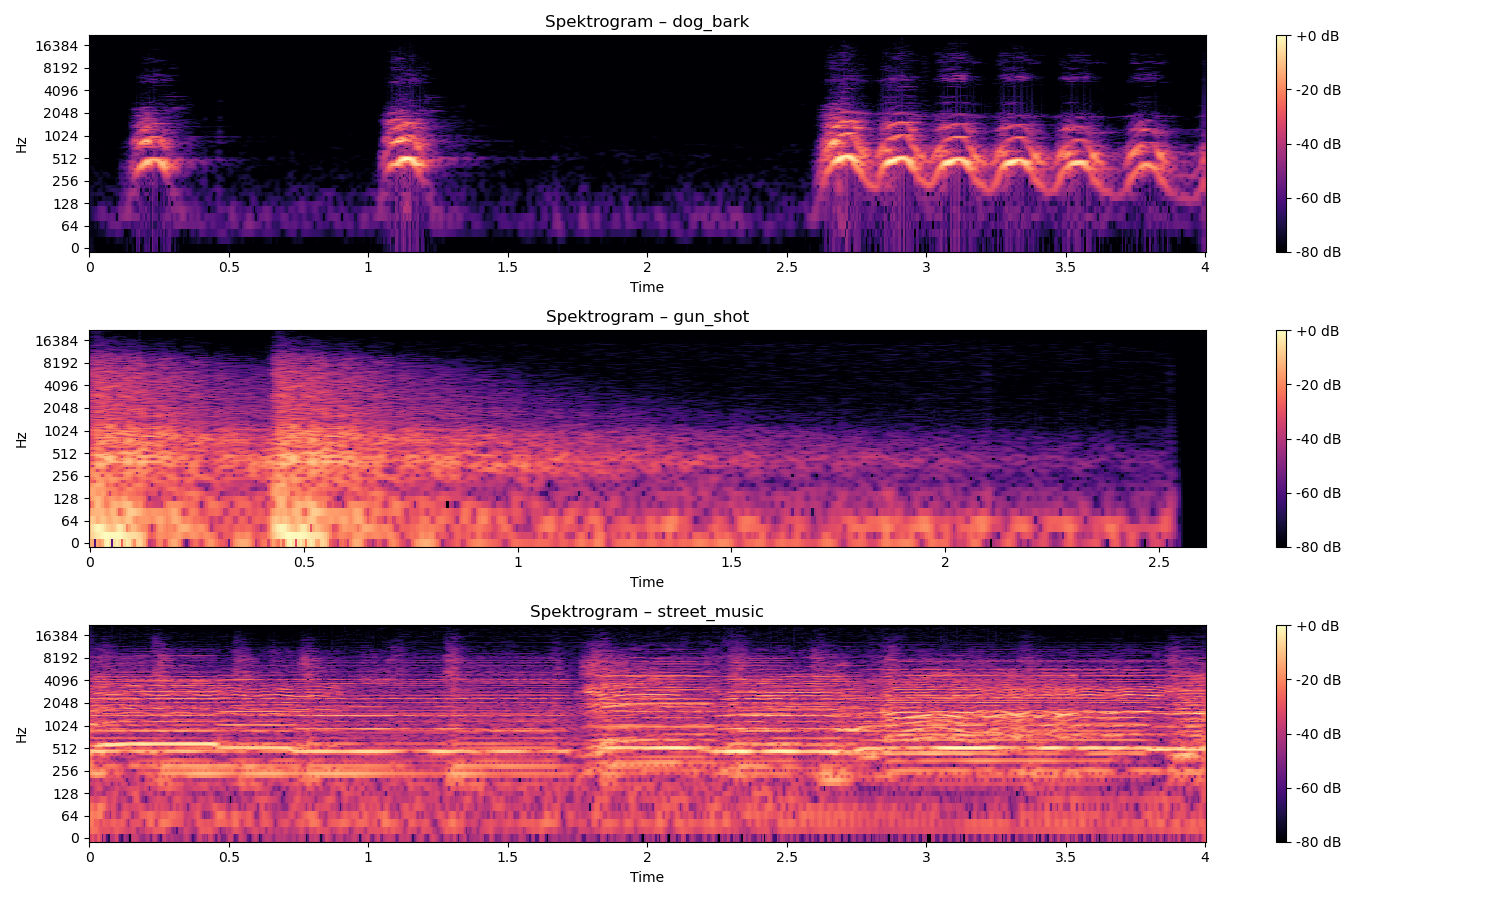

In [3]:
base_path = "./data/train"
classes = ["dog_bark", "gun_shot", "street_music"]

n_fft = 2048          
hop_length = 256      
win_length = 2048    
window = 'hamming'     

plt.figure(figsize=(15, 9))
for i, cls in enumerate(classes):
    file_path = os.path.join(base_path, cls)
    sample_file = os.listdir(file_path)[0]  
    y, sr = librosa.load(os.path.join(file_path, sample_file), sr=None)

    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                            win_length=win_length, window=window))
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    plt.subplot(3, 1, i + 1)
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length,
                              x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spektrogram – {cls}")

plt.tight_layout()
plt.show()

### Objašnjenje

U prikazanom kodu izvršeno je sljedeće:

- Za svaku odabranu klasu zvučnih događaja (`dog_bark`, `gun_shot`, `street_music`) učitan je po jedan audio snimak.
- Na signale je primjenjena kratkotrajna Furijeova transformacija (STFT) koristeći Hammingov prozor dužine 2048 i pomaka od 256 tačaka.
- Dobijeni spektrogrami su konvertovani u decibelsku skalu i prikazani kao funkcije vremena i frekvencije.

Na osnovu spektrograma, moguće je vizuelno razlikovati klase zvučnih događaja, jer svaka klasa ima specifičan frekvencijski potpis:

- Lavež psa se manifestuje kao sekvenca kratkih impulsa u srednjem frekvencijskom opsegu.
- Pucanj iz pištolja pokazuje snažan, širokofrekventni impuls kratkog trajanja kojeg prate šum i eho.
- Ulična muzika prikazuje kontinuirane i višefrekventne strukture, sa jasno vidljivim harmonijama.

Ove razlike omogućavaju efikasno razdvajanje klasa već na osnovu vizuelne analize spektrograma.  


### Zadatak 2

Razmotrite obilježja koja se mogu izračunati na osnovu STFT sa stanovišta njihove upotrebljivosti za prepoznavanje zvučnih događaja.

### Rješenje

Spektralna obilježja izvedena iz STFT pružaju sažet i informativan opis audio signala. Na osnovu vremensko-frekvencijskog prikaza koji daje STFT, moguće je izračunati niz obilježja koja sažimaju strukturu, energiju i dinamiku zvuka.

Na primjer:
- Spectral centroid i bandwidth daju informacije o visini i širini frekvencijskog sadržaja.
- Spectral flux i RMS mjere dinamiku i energiju.
- MFCC koeficijenti modeluju ljudsku percepciju.

Kombinovanjem više obilježja moguće je efikasno razlikovati klase zvučnih događaja na osnovu njihove STFT analize.

Na osnovu materijala koje smo dobili kao domaći zadatak i informacija iz zvanične dokumentacije librosa biblioteke: https://librosa.org/doc/latest/feature.html
biramo nekoliko obilježja.

---

| **Obilježje**           | **Objašnjenje**                                                            | **Korisnost za prepoznavanje**                                         |
|-------------------------|----------------------------------------------------------------------------|------------------------------------------------------------------------|
| **Spectral Centroid**   | "Težište" spektra – gdje je većina energije po frekvencijama              | Visok za razlikovanje `street_music` (visoki tonovi) i `gun_shot`     |
| **Spectral Bandwidth**  | Raspon frekvencija oko centroida                                          | Razlikuje `gun_shot` (širok raspon) i `dog_bark` (uži raspon)         |
| **Spectral Rolloff**    | Frekvencija ispod koje se nalazi 85% energije signala                     | Pomaže razlikovati `street_music` i `dog_bark`                         |
| **Spectral Flux**       | Mjera promjene spektra između susjednih prozora                           | Visok za `dog_bark` i `gun_shot` – imaju nagle promjene               |
| **Spectral Contrast**   | Kontrast između “vrhova” i “padova” unutar jednog prozora                 | Odličan za `street_music` (bogati harmonici)                          |
| **RMS Energy / Peak**   | Jačina zvuka u prozoru                                                    | Pomaže otkriti `gun_shot` (nagla energija)                            |
| **Zero-Crossing Rate**  | Broj prelazaka signala preko nulte ose – mjeri šumovitost                 | Korisno za `gun_shot` (veći broj prelaza)                             |
| **MFCC**                | Mel-Frequency Cepstral Coefficients – približavaju ljudsku percepciju     | Najčešće korištene, stabilne, primjenjive na sve klase                |

---

Svaka klasa zvučnog događaja ima svoj karakteristični frekvencijski opseg i energetsku dinamiku. Kombinovanjem više obilježja (npr. spectral centroid + bandwidth + MFCC), dobijamo vektore obilježja koji omogućavaju algoritmima kao što su k-NN, SVM ili neuronske mreže da nauče razlikovati klase čak i kada se u nekim aspektima preklapaju. Dakle, u praksi kombinovanje više komplementarnih obilježja daje najbolje rezultate — jer nijedno obilježje samo nije dovoljno da uhvati sve razlike među klasama.

### Zadatak 3

Napisati kod u Pythonu za izračunavanje odabranih obilježja za ulazni snimak.

In [4]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    n_fft = 2048
    hop_length = 256

    centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85, n_fft=n_fft, hop_length=hop_length)[0]
    stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    flux = np.sqrt(np.sum(np.diff(stft, axis=1) ** 2, axis=0))
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)[0]
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length)[0]
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)

    features = [
        np.mean(rms), np.std(rms),
        np.mean(zcr), np.std(zcr),
        np.mean(centroid), np.std(centroid),
        np.mean(bandwidth), np.std(bandwidth),
        np.mean(rolloff), np.std(rolloff),
        np.mean(flux), np.std(flux)
    ] + list(np.mean(contrast, axis=1)) + list(np.std(contrast, axis=1)) \
      + list(np.mean(mfcc, axis=1)) + list(np.std(mfcc, axis=1))

    return features

In [5]:
feature_names = [
    'rms_mean', 'rms_std', 'zcr_mean', 'zcr_std',
    'centroid_mean', 'centroid_std', 'bandwidth_mean', 'bandwidth_std',
    'rolloff_mean', 'rolloff_std', 'flux_mean', 'flux_std'
] + [f'contrast_mean_{i}' for i in range(7)] + [f'contrast_std_{i}' for i in range(7)] \
  + [f'mfcc_mean_{i}' for i in range(13)] + [f'mfcc_std_{i}' for i in range(13)]

file_path = "C:/Users/Admin/Desktop/Faks/III/Osnovi digitalne obrade signala/2024-25/Zadace/Druga/data/train/dog_bark/7383-3-0-0.wav"
features = extract_features(file_path)
print("=== Obilježja za jedan snimak ===")
for name, value in zip(feature_names, features):
    print(f"{name}: {value}")

=== Obilježja za jedan snimak ===
rms_mean: 0.026780512183904648
rms_std: 0.038507718592882156
zcr_mean: 0.02913482223731884
zcr_std: 0.009171843465769157
centroid_mean: 1580.2325563359648
centroid_std: 628.377690518977
bandwidth_mean: 2815.7882605261757
bandwidth_std: 1277.8029375392637
rolloff_mean: 2551.9966457201085
rolloff_std: 1513.7234181125436
flux_mean: 6.716455936431885
flux_std: 9.829646110534668
contrast_mean_0: 10.526400257314945
contrast_mean_1: 9.209710304407377
contrast_mean_2: 15.113172931308753
contrast_mean_3: 15.546804074938057
contrast_mean_4: 17.516028876812317
contrast_mean_5: 16.676678894845995
contrast_mean_6: 29.569480728689033
contrast_std_0: 4.109175466139815
contrast_std_1: 3.700617552907719
contrast_std_2: 4.488655062588804
contrast_std_3: 4.231578720940017
contrast_std_4: 3.376256360205148
contrast_std_5: 2.980043970439984
contrast_std_6: 3.4527983307052135
mfcc_mean_0: -436.8661804199219
mfcc_mean_1: 145.61170959472656
mfcc_mean_2: 29.559709548950195
mfc

### Objašnjenje

U datoj funkciji učitava se ulazni audio snimak i izračunavaju se različita obilježja pomenuta u prethodnom zadatku koristeći biblioteku `librosa`.  

- Primjenjuje se STFT sa Hammingovim prozorom i parametrima `n_fft = 2048`, `hop_length = 256`.
- Računaju se obilježja: centroid, bandwidth, rolloff, flux, contrast, RMS, ZCR i MFCC.
- Iz svakog obilježja se izvlače statistički deskriptori: srednja vrijednost i standardna devijacija.
- Povratna vrijednost funkcije je niz sa svim obilježjima spremnim za upotrebu u klasifikaciji.

Korištenjem spektralnih i perceptivnih obilježja moguće je dobiti vektore karakteristika koji precizno opisuju različite aspekte zvučnog signala.  
Ova obilježja su dovoljno informativna i diskriminativna da omoguće pouzdanu klasifikaciju zvučnih događaja kada se koriste u kombinaciji sa klasifikatorima (npr. k-NN).  


### Zadatak 4

Predložite metod za prepoznavanje klase zvučnog događaja na osnovu jednog ili više obilježja iz prethodne tačke. Metod može koristiti poređenje vrijednosti obilježja sa pragom ili jednostavan klasifikator kao što su najbliži susjedi.

### Rješenje

Za klasifikaciju zvučnih događaja koristi se jednostavan, ali efektivan metod k-Najbližih susjeda (k-NN) koji je pomenut i u samom domaćem zadatku.

Za svaki audio snimak (bilo trening ili test) računa se vektor obilježja, koji sadrži obilježja iz prethodne tačke.

Za novi, nepoznati snimak:

1. Izračunamo njegov vektor obilježja.
2. Izračunamo udaljenosti između tog vektora i svih vektora iz trening skupa.
3. Pronađemo k najbližih susjeda (po Euklidskoj udaljenosti).
4. Klasa koja se najčešće pojavljuje među najbližima postaje predikcija za testni snimak.

Prednosti ovog pristupa:
- Jednostavan za implementaciju i razumijevanje.
- Ne zahtijeva obuku modela – koristi se direktno nad podacima.
- Fleksibilan – broj i tip obilježja se mogu lako prilagođavati.


### Zadatak 5

Napisati kod u Pythonu koji na osnovu obilježja snimka određuje klasu zvučnog događaja na tom snimku. Snimke u folderu train koristiti za određivanje vrijednosti praga, odnosno, obučavanje klasifikatora.

In [6]:
def load_dataset(folder_path, return_paths=False):
    X, y, paths = [], [], []
    for label in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, label)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith(".wav"):
                    filepath = os.path.join(class_dir, filename)
                    try:
                        feats = extract_features(filepath)
                        X.append(feats)
                        y.append(label)
                        if return_paths:
                            paths.append(filepath)
                    except Exception as e:
                        print("Greška za fajl", filepath, "->", e)
    if return_paths:
        return np.array(X), np.array(y), paths
    return np.array(X), np.array(y)

In [7]:
def predict(train_dir, test_dir):
    X_train, y_train = load_dataset(train_dir)
    X_test, y_test, test_paths = load_dataset(test_dir, return_paths=True)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    knn.fit(X_train_scaled, y_train)

    y_pred = knn.predict(X_test_scaled)
    print("\n=== Predikcije po fajlovima ===")
    for i, path in enumerate(test_paths):
        print(f"Fajl: {os.path.relpath(path)} | Prava klasa: {y_test[i]} | Predikcija: {y_pred[i]}")

    return y_test, y_pred

In [8]:
train_dir = "./data/train"
test_dir = "./data/test"

y_test, y_pred = predict(train_dir, test_dir)


=== Predikcije po fajlovima ===
Fajl: data\test\dog_bark\118101-3-0-0.wav | Prava klasa: dog_bark | Predikcija: dog_bark
Fajl: data\test\dog_bark\118101-3-0-3.wav | Prava klasa: dog_bark | Predikcija: dog_bark
Fajl: data\test\dog_bark\118101-3-0-4.wav | Prava klasa: dog_bark | Predikcija: dog_bark
Fajl: data\test\dog_bark\118101-3-0-6.wav | Prava klasa: dog_bark | Predikcija: dog_bark
Fajl: data\test\dog_bark\118963-3-0-0.wav | Prava klasa: dog_bark | Predikcija: gun_shot
Fajl: data\test\dog_bark\125791-3-0-12.wav | Prava klasa: dog_bark | Predikcija: dog_bark
Fajl: data\test\dog_bark\125791-3-0-13.wav | Prava klasa: dog_bark | Predikcija: dog_bark
Fajl: data\test\dog_bark\125791-3-0-15.wav | Prava klasa: dog_bark | Predikcija: dog_bark
Fajl: data\test\dog_bark\125791-3-0-9.wav | Prava klasa: dog_bark | Predikcija: dog_bark
Fajl: data\test\dog_bark\130030-3-0-0.wav | Prava klasa: dog_bark | Predikcija: dog_bark
Fajl: data\test\dog_bark\138015-3-0-1.wav | Prava klasa: dog_bark | Predik

### Objašnjenje

Funkcija `load_dataset` je funkcija koja prima putanju do foldera koji sadrži podfoldere (klase) sa .wav fajlovima i boolean parametar koji određuje da li će se vraćati i putanje do fajlova, a vraća: niz obilježja (X), pripadajuće klase (y), i opcionalno putanje do fajlova (paths).

Za svaki .wav fajl u podfolderima:
- računa obilježja pomoću `extract_features`
- dodaje obilježja u listu X
- dodaje naziv klase (naziv foldera) u y
- po želji dodaje i putanju fajla u paths

-----

Funkcija `predict` je funkcija koja prima:
- `train_dir`: folder sa trening snimcima raspoređenim po klasama
- `test_dir`: folder sa test snimcima raspoređenim po klasama

Izlaz iz funkcije:
- `y_test`: stvarne klase test snimaka
- `y_pred`: predviđene klase od strane klasifikatora

Ova funkcija:
1. Učitava podatke:
   * `X_train`, `y_train` – obilježja i klase za trening podatke
   * `X_test`, `y_test`, `test_paths` – obilježja, klase i putanje za test podatke

2. Skalira obilježja:
   * koristi `MinMaxScaler` da normalizuje podatke u opseg `[0, 1]`
   * skalira test podatke istim skaliranjem (da bi bili uporedivi)

3. Trenira klasifikator:
   * koristi k-NN (k najbližih susjeda) sa `k=3` i Euklidovom udaljenošću
   * trenira na skaliranim trening podacima

4. Predviđa klase za test podatke koristeći k-NN klasifikator
5. Za svaki test snimak ispisuje:
    * ime fajla
    * pravu klasu (iz foldera)
    * predikciju klasifikatora

Predloženi sistem koristi kombinaciju akustičkih obilježja dobijenih iz STFT analize i jednostavnog klasifikatora (k-NN) za prepoznavanje i klasifikaciju zvučnih događaja u .wav fajlovima.  

### Zadatak 6

Ocijeniti performanse sistema na snimkama u folderu test. Analizirati kako parametri izdvajanja obilježja i klasifikatora utiču na tačnost prepoznavanja zvučnih događaja.

In [9]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nUkupna tačnost:", accuracy)
print("Matrica konfuzije:\n", conf_matrix)


Ukupna tačnost: 0.9487179487179487
Matrica konfuzije:
 [[11  1  1]
 [ 0 13  0]
 [ 0  0 13]]


### Objašnjenje

* Tačnost: `94.87%`
* Matrica konfuzije: `dog_bark` ima greške, `gun_shot` i `street_music` nemaju

To je vrlo dobra tačnost za jednostavan sistem sa ručno odabranim obilježjima i KNN klasifikatorom.

---

| Parametar                    | Uticaj                                                                                         |
| ---------------------------- | ---------------------------------------------------------------------------------------------- |
| `n_fft` (broj tačaka DFT)    | Viši `n_fft` daje bolju frekvencijsku rezoluciju, ali lošiju vremensku.                        |
| `hop_length` (korak prozora) | Manji korak = više podataka, glatkiji spektrogram, ali sporije računanje.                      |
| `window` (tip prozora)       | Drugi tip prozora može da daje bolje/lošije rezultate.                                                |
| Broj MFCC koeficijenata  | Previše MFCC-ova → šum; premalo → nedovoljno informacija. Obično 13–20.                        |
| `k` (broj susjeda)  | Ako je `k=1`, rezultat je osjetljiv na šum.                |
| Distance metric | Koristi se Euklidska udaljenost, a ponekad kosinusna sličnost bolje radi.    |

Eksperimentisala sam sa brojem `hop_length` i sa većim brojem (512) se brže računao ali je spektrogram imao velike piksele, što znači da je bio manje detaljan i imao je manju frekvencijsku rezoluciju, pa sam se odlučila za broj 256. Takođe sam i povećavala broj tačaka u kojima se računa DFT `n_fft` na 4096 ali spektrogram je izgledao "razvučeno" zbog vremenske rezolucije pa sam ostavila na 2048. Sa manjim brojem zvučnih događaja dobila sam tačnost od \~87%, a sa većim brojem k najbližih susjeda (5) dobila sam tačnost \~92%. Sa ovim trenutnim parametrima dobijam vrlo dobru tačnost pri klasifikaciji od skoro 95%. 

Najveći uticaj na tačnost prepoznavanja zvučnih događaja imaju izbor i broj zvučnih obilježja, kao i pravilno skaliranje podataka. Korištenjem odabranih 8 obilježja: centroid, bandwidth, rolloff, flux, contrast, RMS, ZCR i MFCC, sa određenim brojem koeficijenata, dobili smo informativne reprezentacije signala. Klasifikator k-najbližih susjeda (k=3) uz Euklidsku distancu i skaliranje podataka postigao je tačnost od \~95%. Uočeno je da se klasa `dog_bark` teže klasifikuje, dok su `street_music` i `gun_shot` jasno prepoznatljive.


### Dodatak

Što se tiče upotrebe AI, koristila sam ChatGPT za rad sa `librosa` bibliotekom, ispis rezultata i formatiranje teksta koji je objašnjenje/rješenje zadatka.